[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


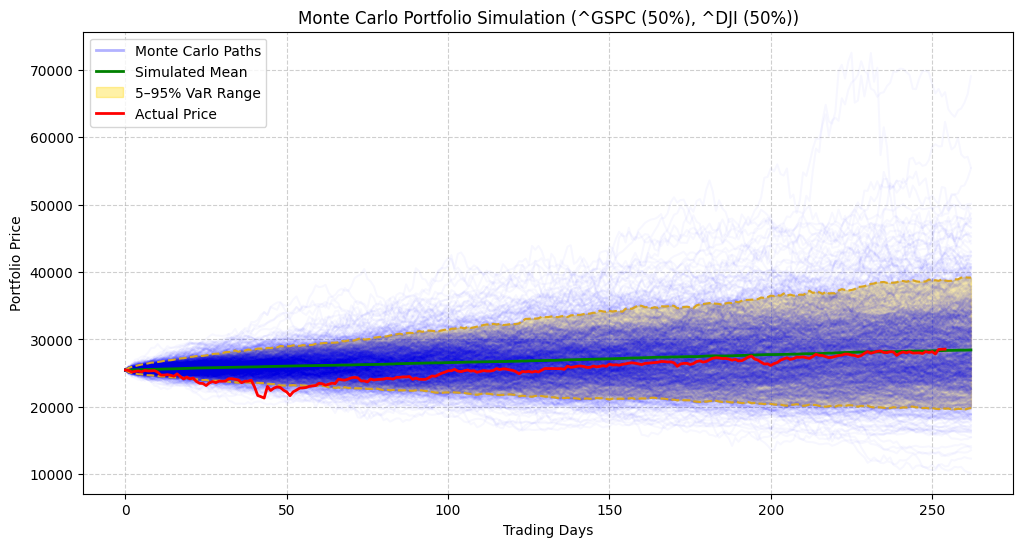

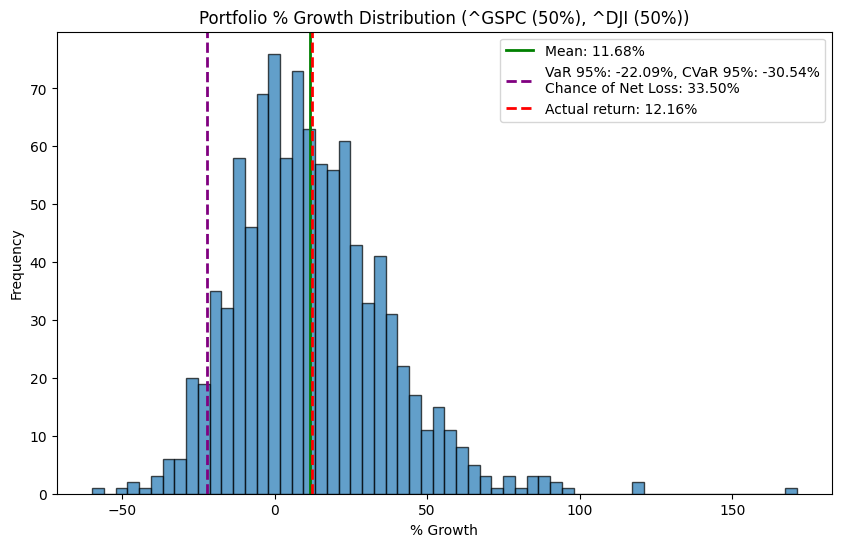

In [1]:
# ============================================================
# Multi-Asset Monte Carlo Portfolio Simulation
# ============================================================

import sqlite3  # SQLite database for storing historical price data
import numpy as np  # Numerical computations
import pandas as pd  # Data manipulation and time series handling
import matplotlib.pyplot as plt  # Plotting
from matplotlib.lines import Line2D  # Custom legend elements
import yfinance as yf  # Download historical market data
from scipy.stats import t  # Student-t distribution (fat-tailed shocks)
from arch import arch_model  # GARCH volatility modeling
from numba import njit  # JIT compiler for performance optimization

# ============================================================
# ------------------- CONFIG / PARAMETERS --------------------
# ============================================================
CONFIG = {
    "tickers": ['^GSPC','^DJI'],  # Assets in the portfolio (S&P 500 and Dow Jones)
    "weights": np.array([0.5,0.5]),  # Portfolio weights (must sum to 1 ideally)
    "start_date": '2025-02-05',  # Simulation start date
    "end_date": '2026-02-05',  # Simulation end date
    "paths": 1000,  # Number of Monte Carlo paths
    "df_tails": 15,  # Degrees of freedom for Student-t shocks (controls tail heaviness)
    "vol_window": 30,  # Rolling window for initial volatility estimate
    "max_daily_return": None,  # Optional cap on daily returns (risk control)
    "return_type": "simple",  # "log" or "simple" returns
    "db_file": "stocks.db"  # SQLite database file name
}

# ============================================================
# --------------------------- CORE ---------------------------
# ============================================================

@njit  # Compiles function for speed (important for Monte Carlo loops)
def _simulate_garch_paths(
    T, paths,
    omega, alpha, beta,  # GARCH(1,1) parameters
    mu_paths,  # Drift term per path
    sigma2_init,  # Initial variance
    shocks,  # Random shocks (possibly correlated)
    max_daily_return,  # Optional clipping threshold
    use_clip  # Boolean flag to enable clipping
):
    returns_sim = np.zeros((T, paths))  # Store simulated returns
    sigma2 = np.zeros((T + 1, paths))  # Store variance evolution

    for p in range(paths):
        sigma2[0, p] = sigma2_init  # Initialize variance for each path

    for t_step in range(T):
        for p in range(paths):

            prev_ret_sq = 0.0
            if t_step > 0:
                prev_ret_sq = returns_sim[t_step - 1, p] ** 2  # Squared previous return

            # GARCH(1,1) variance update equation
            sigma2[t_step + 1, p] = (
                omega
                + alpha * prev_ret_sq
                + beta * sigma2[t_step, p]
            )

            sigma_t = np.sqrt(sigma2[t_step + 1, p])  # Volatility
            r_t = mu_paths[p] + sigma_t * shocks[t_step, p]  # Return equation

            # Optional return clipping to limit extreme shocks
            if use_clip:
                if r_t > max_daily_return:
                    r_t = max_daily_return
                elif r_t < -max_daily_return:
                    r_t = -max_daily_return

            returns_sim[t_step, p] = r_t  # Store return

    return returns_sim


@njit  # JIT compilation for speed
def _build_price_paths(S0, returns_sim, return_type_log):
    T, paths = returns_sim.shape
    prices = np.zeros((T + 1, paths))
    prices[0, :] = S0  # Initial price

    for p in range(paths):

        if return_type_log:
            cumulative = 0.0  # Log-return accumulation
            for t in range(T):
                cumulative += returns_sim[t, p]
                prices[t + 1, p] = S0 * np.exp(cumulative)  # Convert log returns to price
        else:
            cumulative = 1.0  # Multiplicative accumulation for simple returns
            for t in range(T):
                cumulative *= (1.0 + returns_sim[t, p])
                prices[t + 1, p] = S0 * cumulative

    return prices

# ============================================================
# ------------------- DATABASE MODULE ------------------------
# ============================================================

class StockDB:
    def __init__(self, db_file):
        self.conn = sqlite3.connect(db_file)  # Open DB connection
        self._create_table()

    def _create_table(self):
        # Create table if not exists
        self.conn.execute("""
            CREATE TABLE IF NOT EXISTS stock_prices (
                ticker TEXT,
                date TEXT,
                close_price REAL
            )
        """)
        self.conn.commit()

    def save_stock_data(self, ticker, df):
        # Append new data
        df.to_sql('stock_prices', self.conn, if_exists='append', index=False)

        # Remove duplicates (keep earliest rowid)
        self.conn.execute("""
            DELETE FROM stock_prices
            WHERE rowid NOT IN (
                SELECT MIN(rowid)
                FROM stock_prices
                GROUP BY ticker, date
            )
        """)
        self.conn.commit()

    def load_stock_data(self, ticker):
        # Load data for one ticker
        df = pd.read_sql(
            f"SELECT * FROM stock_prices WHERE ticker='{ticker}'",
            self.conn
        )
        df['date'] = pd.to_datetime(df['date'])
        return df.sort_values('date').reset_index(drop=True)

    def close(self):
        self.conn.close()

# ============================================================
# ------------------- DATA DOWNLOAD MODULE -------------------
# ============================================================

def download_and_store(tickers, db_file, end_date):
    # Downloads historical data and stores in SQLite DB
    db = StockDB(db_file)
    for ticker in tickers:
        df = yf.download(
            ticker,
            start='2021-01-01',  # Hardcoded history start date
            end=pd.Timestamp(end_date) + pd.Timedelta(days=1)
        )
        df = df[['Close']].reset_index()
        df.columns = ['date', 'close_price']
        df['ticker'] = ticker
        db.save_stock_data(ticker, df)
    db.close()

# ============================================================
# ----------------- ALIGN DATES FOR HOLIDAYS -----------------
# ============================================================

def align_actual_prices(all_actual, start_date, end_date):
    # Align multiple assets to common business-day index
    date_ranges = []
    price_series = []

    for prices in all_actual:
        dates = pd.bdate_range(start=start_date, periods=len(prices))
        date_ranges.append(dates)
        price_series.append(pd.Series(prices, index=dates))

    # Find intersection of all trading days
    common_dates = date_ranges[0]
    for dr in date_ranges[1:]:
        common_dates = common_dates.intersection(dr)

    aligned_actuals = [s.reindex(common_dates).values for s in price_series]
    return np.array(aligned_actuals), common_dates

# ============================================================
# ----------- RESIDUAL CORRELATION ESTIMATION ----------------
# ============================================================

def estimate_residual_correlation(tickers, db_file, start_date):
    # Estimate correlation of standardized GARCH residuals
    residuals = []

    for ticker in tickers:
        db = StockDB(db_file)
        df = db.load_stock_data(ticker)
        db.close()

        df = df[df['date'] < pd.Timestamp(start_date)]
        returns = df['close_price'].pct_change().dropna()

        # Fit GARCH model
        am = arch_model(returns * 100, vol='Garch', p=1, q=1, dist='t')
        res = am.fit(disp='off')

        residuals.append(res.std_resid.values)

    # Align residual lengths
    min_len = min(len(r) for r in residuals)
    residuals = np.array([r[-min_len:] for r in residuals])

    return np.corrcoef(residuals)

# ============================================================
# ------------------- SIMULATION MODULE ----------------------
# ============================================================

class StockSimulator:
    # Simulates a single asset using GARCH Monte Carlo
    def __init__(self, ticker, start_date, end_date, paths,
                 df_tails=15, vol_window=30, max_daily_return=0.2,
                 return_type="log", db_file="stocks.db"):

        self.ticker = ticker
        self.start_date = pd.Timestamp(start_date)
        self.end_date = pd.Timestamp(end_date)
        self.paths = paths
        self.df_tails = df_tails
        self.vol_window = vol_window
        self.max_daily_return = max_daily_return
        self.return_type = return_type
        self.db_file = db_file

        self.prices = None
        self.actual_prices = None
        self.trading_days = None

    def _fit_garch(self, returns):
        # Fit GARCH(1,1) with Student-t innovations
        scaled = returns * 100
        am = arch_model(scaled, vol='Garch', p=1, q=1, dist='t')
        res = am.fit(disp='off')
        return res

    def simulate(self, external_shocks=None):
        # Main simulation logic

        db = StockDB(self.db_file)
        df = db.load_stock_data(self.ticker)
        db.close()

        df_future = df[df['date'] >= self.start_date]
        if df_future.empty:
            raise ValueError(f"No actual data for {self.ticker} after {self.start_date}")

        first_idx = df_future.index[0]
        S0 = df_future.loc[first_idx, 'close_price']  # Starting price
        hist = df.loc[:first_idx - 1].copy()

        # Compute historical returns
        if self.return_type == "log":
            hist['returns'] = np.log(hist['close_price']).diff()
            return_type_log = True
        else:
            hist['returns'] = hist['close_price'].pct_change()
            return_type_log = False

        hist = hist.dropna()

        # Fit GARCH parameters
        res = self._fit_garch(hist['returns'])
        omega = res.params['omega'] / 100**2
        alpha = res.params['alpha[1]']
        beta = res.params['beta[1]']

        # Drift uncertainty per path
        mu_hat = hist['returns'].mean()
        mu_std = hist['returns'].std() / np.sqrt(len(hist))
        mu_paths = np.random.normal(mu_hat, mu_std, size=self.paths)

        self.trading_days = pd.bdate_range(self.start_date, self.end_date)
        T = len(self.trading_days)

        # Initial volatility estimate
        hist_vol = hist['returns'].rolling(self.vol_window).std().dropna()
        sigma2_init = hist_vol.iloc[-1] ** 2 if len(hist_vol) > 0 else hist['returns'].std() ** 2

        # Generate shocks (or use correlated ones)
        if external_shocks is None:
            shocks = t.rvs(df=self.df_tails, size=(T, self.paths))
        else:
            shocks = external_shocks

        use_clip = self.max_daily_return is not None
        max_ret = self.max_daily_return if use_clip else 0.0

        # Simulate return paths
        returns_sim = _simulate_garch_paths(
            T, self.paths,
            omega, alpha, beta,
            mu_paths,
            sigma2_init,
            shocks,
            max_ret,
            use_clip
        )

        # Convert returns to price paths
        self.prices = _build_price_paths(S0, returns_sim, return_type_log)
        self.actual_prices = df_future['close_price'].values

        return self.prices, self.actual_prices, self.trading_days


# ============================================================
# ------------------- PORTFOLIO MODULE -----------------------
# ============================================================

class PortfolioSimulator:
    # Combines multiple StockSimulators into weighted portfolio
    def __init__(self, tickers, weights, start_date, end_date, paths, **kwargs):
        self.tickers = tickers
        self.weights = np.array(weights)
        self.start_date = start_date
        self.end_date = end_date
        self.paths = paths
        self.kwargs = kwargs

        self.all_prices = []
        self.all_actual = []
        self.portfolio_prices = None
        self.actual_prices = None

    def simulate(self):

        # Estimate residual correlation matrix
        corr = estimate_residual_correlation(
            self.tickers,
            self.kwargs.get("db_file", "stocks.db"),
            self.start_date
        )

        # Cholesky decomposition for correlated shocks
        chol = np.linalg.cholesky(corr)

        T = len(pd.bdate_range(self.start_date, self.end_date))
        n_assets = len(self.tickers)

        # Generate independent Student-t shocks
        raw_shocks = t.rvs(
            df=self.kwargs.get("df_tails", 15),
            size=(n_assets, T, self.paths)
        )

        # Correlate shocks across assets
        correlated_shocks = np.einsum('ij,jtp->itp', chol, raw_shocks)

        for i, ticker in enumerate(self.tickers):
            sim = StockSimulator(
                ticker,
                self.start_date,
                self.end_date,
                self.paths,
                **self.kwargs
            )
            prices, actual, _ = sim.simulate(
                external_shocks=correlated_shocks[i]
            )
            self.all_prices.append(prices)
            self.all_actual.append(actual)

        self.all_prices = np.array(self.all_prices)

        # Weighted portfolio price paths
        self.portfolio_prices = np.tensordot(
            self.all_prices, self.weights, axes=(0, 0)
        )

        # Align actual prices across assets
        self.all_actual, _ = align_actual_prices(
            self.all_actual, self.start_date, self.end_date
        )

        # Weighted actual portfolio price
        self.actual_prices = np.dot(self.all_actual.T, self.weights)

        return self.portfolio_prices, self.actual_prices


# ============================================================
# ------------------- PLOTTING MODULE ------------------------
# ============================================================

def plot_portfolio(portfolio_prices, actual_prices=None, tickers=None, weights=None):
    # Compute 5–95% VaR band across simulations
    VaR_lower = np.percentile(portfolio_prices, 5, axis=1)
    VaR_upper = np.percentile(portfolio_prices, 95, axis=1)

    plt.figure(figsize=(12, 6))
    plt.grid(True, linestyle='--', alpha=0.6)

    # All Monte Carlo paths
    plt.plot(portfolio_prices, color='blue', alpha=0.03)

    # Mean path
    plt.plot(portfolio_prices.mean(axis=1), color='green', lw=2, label='Simulated Mean')

    # VaR band
    plt.fill_between(
        range(len(portfolio_prices)),
        VaR_lower, VaR_upper,
        color='gold', alpha=0.35, label='5–95% VaR Range'
    )

    plt.plot(VaR_lower, linestyle='--', color='goldenrod')
    plt.plot(VaR_upper, linestyle='--', color='goldenrod')

    # Overlay actual prices if available
    if actual_prices is not None:
        plt.plot(actual_prices[:len(portfolio_prices)],
                 color='red', lw=2, label='Actual Price')

    # Dynamic title with weights
    if tickers is not None and weights is not None:
        ticker_weights = [f"{t} ({w*100:.0f}%)" for t, w in zip(tickers, weights)]
        title = f"Monte Carlo Portfolio Simulation ({', '.join(ticker_weights)})"
    else:
        title = "Monte Carlo Portfolio Simulation"

    plt.title(title)
    plt.xlabel("Trading Days")
    plt.ylabel("Portfolio Price")

    # Custom legend entry for MC paths
    mc_proxy = Line2D([0], [0], color='blue', lw=2, alpha=0.3, label='Monte Carlo Paths')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [mc_proxy] + handles
    labels = ['Monte Carlo Paths'] + labels
    plt.legend(handles, labels, loc='upper left')

    plt.show()


def plot_growth_distribution(portfolio_prices, actual_prices=None, tickers=None, weights=None):
    # Compute final return distribution
    final_prices = portfolio_prices[-1]
    final_returns = (final_prices / portfolio_prices[0,0] - 1) * 100

    # Compute actual return if available
    if actual_prices is not None:
        last_idx = min(len(actual_prices), len(portfolio_prices)) - 1
        actual_return = (actual_prices[last_idx] / actual_prices[0] - 1) * 100
    else:
        actual_return = None

    # Risk metrics
    var95 = np.percentile(final_returns, 5)
    cvar95 = final_returns[final_returns <= var95].mean()
    chance_of_loss = np.mean(final_returns < 0) * 100

    plt.figure(figsize=(10,6))
    plt.hist(final_returns, bins=60, alpha=0.7, edgecolor='black')

    plt.axvline(final_returns.mean(), color='green', lw=2,
                label=f"Mean: {final_returns.mean():.2f}%")

    plt.axvline(var95, color='purple', lw=2, linestyle='--',
                label=f"VaR 95%: {var95:.2f}%, CVaR 95%: {cvar95:.2f}%\nChance of Net Loss: {chance_of_loss:.2f}%")

    if actual_return is not None:
        plt.axvline(actual_return, color='red', lw=2, linestyle='--',
                    label=f"Actual return: {actual_return:.2f}%")

    if tickers is not None and weights is not None:
        ticker_weights = [f"{t} ({w*100:.0f}%)" for t, w in zip(tickers, weights)]
        title = f"Portfolio % Growth Distribution ({', '.join(ticker_weights)})"
    else:
        title = "Portfolio % Growth Distribution"

    plt.title(title)
    plt.xlabel("% Growth")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


# ============================================================
# ------------------- MAIN EXECUTION -------------------------
# ============================================================

if __name__ == "__main__":
    # Download historical data and store in DB
    download_and_store(CONFIG['tickers'], CONFIG['db_file'], CONFIG['end_date'])

    # Run portfolio simulation
    portfolio_sim = PortfolioSimulator(**CONFIG)
    portfolio_prices, actual_prices = portfolio_sim.simulate()

    # Plot Monte Carlo paths vs actual
    plot_portfolio(portfolio_prices, actual_prices,
                   tickers=CONFIG['tickers'], weights=CONFIG['weights'])

    # Plot terminal return distribution and risk metrics
    plot_growth_distribution(portfolio_prices, actual_prices,
                             tickers=CONFIG['tickers'], weights=CONFIG['weights'])


Portfolio Simulation Test Case:
Tickers: ['^GSPC', '^DJI']
Weights: [0.5, 0.5]
Mean final return: 13.68%
Std dev of final return: 24.48%
5% VaR (downside threshold): -20.07%
95% percentile (upside threshold): 56.23%
Probability of negative return: 29.66%
Actual final return: 12.16%
Deviation from simulated mean: -1.51%


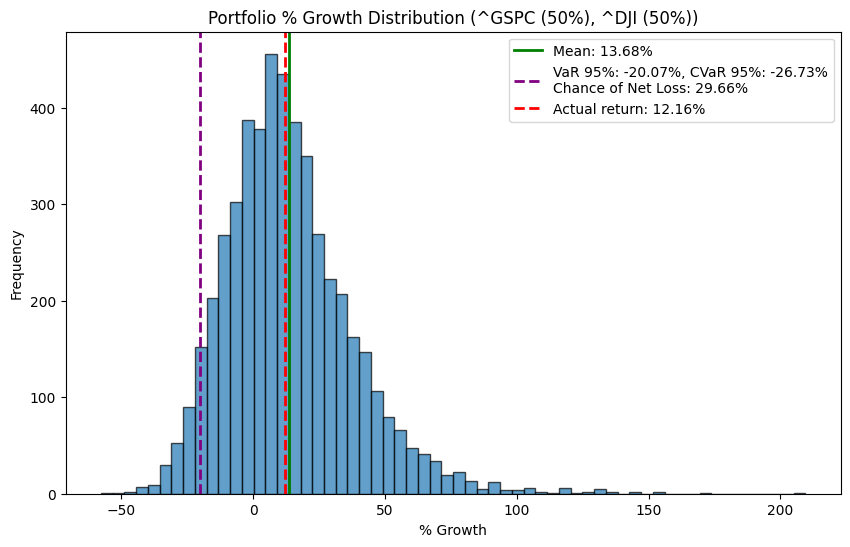

In [4]:
# ============================================================
# RECRUITER TEST CASE (RUN THIS CELL)
# ============================================================


# --- Test Parameters ---
test_tickers = ['^GSPC','^DJI']  # Assets to test (S&P 500 and Dow Jones)
test_weights = [0.5, 0.5]  # 50% / 50% portfolio allocation
test_start = '2025-02-05'  # Simulation start date
test_end = '2026-02-05'  # Simulation end date
test_paths = 5000  # Number of Monte Carlo paths (higher = smoother distribution)

# --- Run Portfolio Simulation ---
# Create portfolio simulator instance using same DB as main run
portfolio_sim_test = PortfolioSimulator(
    tickers=test_tickers,
    weights=test_weights,
    start_date=test_start,
    end_date=test_end,
    paths=test_paths,
    df_tails=15,  # Fat-tail parameter (Student-t degrees of freedom)
    vol_window=30,  # Rolling window for initial volatility
    max_daily_return=0.2,  # Cap extreme daily returns at ±20%
    return_type="log",  # Use log returns for simulation
    db_file=CONFIG['db_file']  # Reuse existing historical database
)

# Run simulation
portfolio_prices, actual_prices = portfolio_sim_test.simulate()

# --- Compute Key Metrics (ALL IN %) ---
# Extract final simulated portfolio values
final_sim_values = portfolio_prices[-1]

# Convert everything to percentage return relative to initial value
initial_value = portfolio_prices[0, 0]
final_returns_pct = (final_sim_values / initial_value - 1) * 100

# Mean final return (%)
mean_final = np.mean(final_returns_pct)

# Standard deviation of final returns (%)
std_final = np.std(final_returns_pct)

# 5% Value at Risk (left tail percentile, %)
var_5 = np.percentile(final_returns_pct, 5)

# 95% percentile (upper bound, %)
var_95 = np.percentile(final_returns_pct, 95)

# Probability of negative return (%)
prob_loss = np.mean(final_returns_pct < 0) * 100

print(f"Portfolio Simulation Test Case:")
print(f"Tickers: {test_tickers}")
print(f"Weights: {test_weights}")

# Report all metrics explicitly as percentages
print(f"Mean final return: {mean_final:.2f}%")
print(f"Std dev of final return: {std_final:.2f}%")
print(f"5% VaR (downside threshold): {var_5:.2f}%")
print(f"95% percentile (upside threshold): {var_95:.2f}%")
print(f"Probability of negative return: {prob_loss:.2f}%")

# If actual data exists, compare actual return in %
if actual_prices is not None:
    actual_final = actual_prices[-1]
    actual_return_pct = (actual_final / actual_prices[0] - 1) * 100

    print(f"Actual final return: {actual_return_pct:.2f}%")
    print(f"Deviation from simulated mean: {(actual_return_pct - mean_final):.2f}%")

# --- Plots ---
# Plot return distribution (already expressed in % inside function)
plot_growth_distribution(portfolio_prices, actual_prices, tickers=test_tickers, weights=test_weights)
